In [30]:
import numpy as np
import tifffile
import imageio.v3 as iio
import matplotlib.pyplot as plt
from shapely import wkt
from rasterio.transform import from_bounds
import rasterio
from scipy.ndimage import uniform_filter
from skimage.morphology import (
    binary_opening, binary_closing, binary_dilation,
    remove_small_objects, remove_small_holes, disk
)

In [31]:
# --- Parameters ---
image_path = "/Users/ereilly/Documents/code/OilClassification/Output/ContrastRatio/S1A_IW_GRDH_1SDV_20240725T015015_20240725T015044_054911_06B032_3EFF_pre/S1A_IW_GRDH_1SDV_20240725T015015_20240725T015044_054911_06B032_3EFF_pre_JPL0.4_VVDR_cumulative.tif"
output_path = "oil_slick_mask_final_0725_1.tif"
wkt_aoi = "POLYGON ((-117.171936 32.379961, -117.055206 32.379961, -117.055206 32.638218, -117.171936 32.638218, -117.171936 32.379961))"
threshold_value = 0.11

In [32]:
# --- Step 1: Load image ---
image = iio.imread(image_path).astype(np.float32)

# --- Step 2: NaN-safe low-pass filter ---
valid_mask = (~np.isnan(image)).astype(np.float32)
image_filled = np.nan_to_num(image, nan=0.0)
numerator = uniform_filter(image_filled, size=3, mode='nearest')
denominator = uniform_filter(valid_mask, size=3, mode='nearest')
smoothed = np.full_like(image, np.nan, dtype=np.float32)
nonzero_mask = denominator > 0
smoothed[nonzero_mask] = numerator[nonzero_mask] / denominator[nonzero_mask]

In [33]:
# --- Step 3: Thresholding and segmentation ---
signal_mask = (smoothed > threshold_value) & ~np.isnan(smoothed)
clean_mask = binary_opening(signal_mask, disk(2))
clean_mask = binary_closing(clean_mask, disk(3))
clean_mask = remove_small_holes(clean_mask, area_threshold=300)
clean_mask = remove_small_objects(clean_mask, min_size=100)
expanded_mask = binary_dilation(clean_mask, disk(2))  # final result

In [34]:
# --- Step 4: Create raster transform from WKT AOI ---
geom = wkt.loads(wkt_aoi)
min_lon, min_lat, max_lon, max_lat = geom.bounds
height, width = expanded_mask.shape
transform = from_bounds(min_lon, min_lat, max_lon, max_lat, width, height)

In [35]:
# --- Step 5: Save binary mask as GeoTIFF ---
profile = {
    "driver": "GTiff",
    "dtype": "uint8",
    "count": 1,
    "height": height,
    "width": width,
    "crs": "EPSG:4326",
    "transform": transform,
    "nodata": 0
}

with rasterio.open(output_path, "w", **profile) as dst:
    dst.write(expanded_mask.astype("uint8"), 1)

print(f"Saved: {output_path}")


Saved: oil_slick_mask_final_0725_1.tif


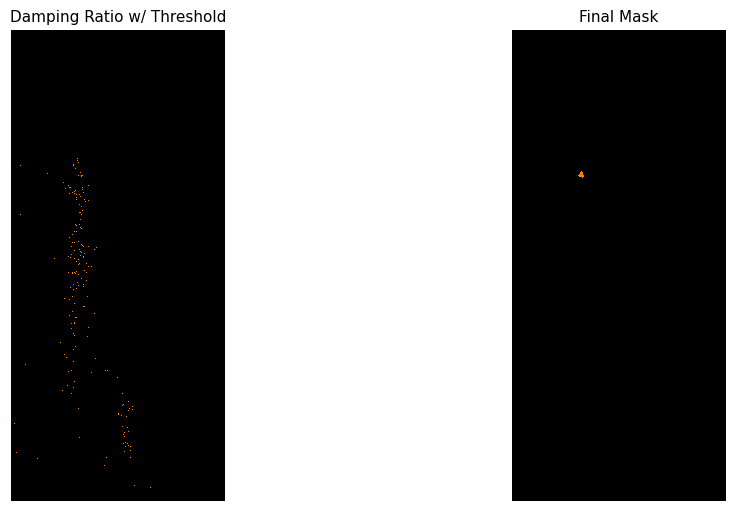

In [40]:
from matplotlib.colors import ListedColormap

# Orange colormap: 0 = black, 1 = orange
orange_on_black = ListedColormap([
    (0.0, 0.0, 0.0, 1.0),  # black background
    (1.0, 0.5, 0.0, 1.0)   # orange foreground
])

# Build binary masks for display
input_mask = ((image != 0) & ~np.isnan(image)).astype(np.uint8)
mask_display = expanded_mask.astype(np.uint8)

# Create figure with white background
fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
fig.patch.set_facecolor('white')  # white figure canvas

# Show original input (orange if > 0, black otherwise)
axes[0].imshow(input_mask, cmap=orange_on_black, interpolation='none')
axes[0].set_title("Damping Ratio w/ Threshold", fontsize=11)
axes[0].axis('off')

# Show final mask (orange if in mask, black otherwise)
axes[1].imshow(mask_display, cmap=orange_on_black, interpolation='none')
axes[1].set_title("Final Mask", fontsize=11)
axes[1].axis('off')

plt.show()